1. import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from scipy.stats import norm, t
import os

2. data Acquisition and Cleaning

In [31]:
##defining portfolio - through .csv upload in final script
tickers = ['SPY', 'QQQ', 'BND', 'AAPL', 'GOOG']
weights = np.array([0.3, 0.2, 0.2, 0.15, 0.15])
pf_value = 1000000
##sanity checking weights match tickers and equal 1
assert len(weights) == len(tickers), 'Weights and tickers length must match'
assert np.isclose(np.sum(weights), 1), 'Weights must sum to 1'

##defining dates
years = 5 ##customizable by user
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days = 365 * years)
days = 1

##creating list of confidence levels
conf_levels = [0.9, 0.95, 0.99]

##inclusion/exclusion of drift loss
mean_ignore = False

##create a df for the adj close prices to be pulled from yf
df_adj_close = pd.DataFrame()
##creating a for loop to pull prices from all tickers for chosen dates
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date, auto_adjust = True)
    df_adj_close[ticker] = data['Close']

##calculation daily log returns and dropping NaNs
log_returns = np.log(df_adj_close / df_adj_close.shift(1))
log_returns = log_returns.dropna()

##creating folder for subsequent exports
folder_name = f'portfolioname_{days}_days_return_{years}_years_data_{pf_value}_portfolio_value' ##when made to script change to grab name from original .csv file
output_path = os.path.join(os.getcwd(), folder_name)

if not os.path.exists(output_path):
    os.makedirs(output_path)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


3. portfolio returns and variance-covariance matrix

In [32]:
##calculating portfolio returns (time series)
weighted_returns = np.multiply(weights, log_returns)
pf_returns = np.sum(weighted_returns, axis = 1)

##finding the annualized portfolio mean return
pf_mean_daily = pf_returns.mean()
pf_mean = pf_mean_daily * 252

##calculating the annualized portfolio std
##creating variance-covariance matrix multiplying with 252 to get 1 year std
vcv_matrix = log_returns.cov() * 252 

##calculation the std
pf_std = np.sqrt(weights.T @ vcv_matrix @ weights)

4. VaR and CVaR using the parametric method

In [33]:
##first, creating lists for the VaRs and CVaRs to be stored
VaRs_para = []
CVaRs_para = []

##then find mean return and std over the horizon
mean_T = pf_mean * (days/252)
std_T = pf_std * np.sqrt(days/252)

##then find mean and std loss over the horizon
if mean_ignore == True:
    mean_loss = 0
else:
    mean_loss =  -pf_value * mean_T
std_loss = pf_value * std_T

##creating a loop to get the parametric VaRs and CVaRs
for cl in conf_levels:
    z_cl = norm.ppf(cl)
    phi_z_cl = norm.pdf(z_cl)

    ##calculating VaR and CVaR as positive USD losses
    VaR_para = std_loss * z_cl + mean_loss
    CVaR_para = std_loss * (phi_z_cl/(1 - cl)) + mean_loss
    
    VaRs_para.append(VaR_para)
    CVaRs_para.append(CVaR_para)

5. VaR and CVaR using the historical method

In [34]:
##calculating the rolling historical returns
pf_returns_rolling = pf_returns.rolling(window = days).sum()
pf_returns_rolling = pf_returns_rolling.dropna()

##Creating lists for the VaRs and CVaRs to be stored
VaRs_his = []
CVaRs_his = []

##creating a loop to identify the VaR and CVaR at the confidence levels' percentile
for cl in conf_levels:
    VaR_cutoff_his = np.percentile(pf_returns_rolling, 100 - (cl * 100))
    VaR_his = -VaR_cutoff_his * pf_value
    
    mask_his = pf_returns_rolling < VaR_cutoff_his
    tail_his = pf_returns_rolling[mask_his]
    CVaR_his = -tail_his.mean() * pf_value
    
    VaRs_his.append(VaR_his)
    CVaRs_his.append(CVaR_his)

6. VaR and CVaR using a Monte Carlo simulation with Student's t distribution

In [35]:
##setting degrees of freedom nu to align with historical data
r_std = (pf_returns - pf_returns.mean()) / pf_returns.std()
nu = t.fit(r_std, floc = 0, fscale = 1)[0]

##creating function giving a random z-score to be a standardized t‑draw
def random_z():
    t_draw = t.rvs(df = nu)
    return t_draw * np.sqrt((nu - 2)/ nu)

##creating function to calculate scenarioGainLoss
def scenario_gain_loss(pf_value, mean_T, std_T, z_score):
    pnl = pf_value * mean_T + pf_value * std_T * z_score
    return -pnl

##running simulations of gains/losses and storing the values
simulations = 50000
scenario_return = []

for i in range(simulations):
    z_score = random_z()
    scenario_return.append(scenario_gain_loss(pf_value, mean_T, std_T, z_score))

##convert to array after all values are appended
scenario_return = np.array(scenario_return)

##Creating lists for the VaRs and CVaRs to be stored
VaRs_mc = []
CVaRs_mc = []

##creating a loop to identify the VaR and CVaR at the confidence levels' percentile based on simulation results
for cl in conf_levels:
    VaR_mc = np.percentile(scenario_return, 100 * cl)

    mask_mc = scenario_return > VaR_mc
    tail_mc = scenario_return[mask_mc]
    CVaR_mc = tail_mc.mean()
    
    VaRs_mc.append(VaR_mc)
    CVaRs_mc.append(CVaR_mc)

7. creating dataframe to compare VaR and CVaR across the three different methods

In [29]:
##organizing the data for the dataframe
data = {
    'Confidence Level': ['90%', '95%', '99%'],
    'VaR: Parametric Method': [VaRs_para[0], VaRs_para[1], VaRs_para[2]],
    'VaR: Historical Method': [VaRs_his[0], VaRs_his[1], VaRs_his[2]],
    'VaR: Monte Carlo Simulation': [VaRs_mc[0], VaRs_mc[1], VaRs_mc[2]],
    'CVaR: Parametric Method': [CVaRs_para[0], CVaRs_para[1], VaRs_para[2]],
    'CVaR: Historical Method': [CVaRs_his[0], CVaRs_his[1], CVaRs_his[2]],
    'CVaR: Monte Carlo Simulation': [CVaRs_mc[0], CVaRs_mc[1], CVaRs_mc[2]],
}

##creating the pd dataframe with the organized data
df_VaRs_CVaRs = pd.DataFrame(data)
df_VaRs_CVaRs = df_VaRs_CVaRs.set_index('Confidence Level')

##export to .csv file
df_VaRs_CVaRs.to_csv(os.path.join(output_path, 'VaRs_CVaRs.csv'))

8. visualization of returns, VaR and CVaR

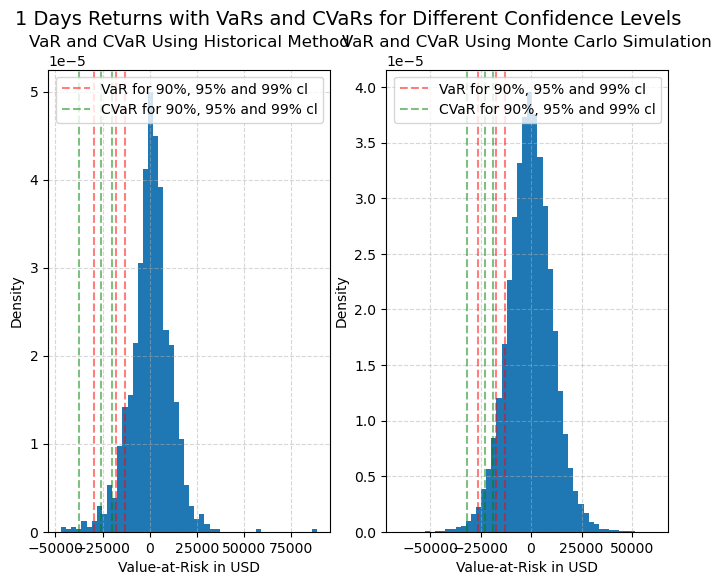

In [36]:
##creating dollar amount values for histograms
pf_returns_rolling_dollar = pf_returns_rolling * pf_value

##density plots of historical and monte carlo returns next to each other
##creating a figure with 2 x-axes
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 6))

##creating the two separate histograms
axes[0].hist(pf_returns_rolling_dollar, bins = 50, density = True);
axes[1].hist(scenario_return, bins = 50, density = True);

##adding vertical lines to represent VaR and CVaR with for loops
for VaR_his in VaRs_his:
    axes[0].axvline(-VaR_his, color = 'red', linestyle = '--', alpha = 0.5,
                   label = 'VaR for 90%, 95% and 99% cl'
                       if VaR_his == VaRs_his[0]
                       else '_nolegend_')
for CVaR_his in CVaRs_his:
    axes[0].axvline(-CVaR_his, color = 'green', linestyle = '--', alpha = 0.5,
                    label = 'CVaR for 90%, 95% and 99% cl'
                        if CVaR_his == CVaRs_his[0]
                        else '_nolegend_')
axes[0].legend()
for VaR_mc in VaRs_mc:
    axes[1].axvline(-VaR_mc, color = 'red', linestyle = '--', alpha = 0.5,
                    label = 'VaR for 90%, 95% and 99% cl'
                        if VaR_mc == VaRs_mc[0]
                        else '_nolegend_')
for CVaR_mc in CVaRs_mc:
    axes[1].axvline(-CVaR_mc, color = 'green', linestyle = '--', alpha = 0.5,
                    label = 'CVaR for 90%, 95% and 99% cl'
                        if CVaR_mc == CVaRs_mc[0]
                        else '_nolegend_')
axes[1].legend()


##fix labels
fig.suptitle(f'{days} Days Returns with VaRs and CVaRs for Different Confidence Levels', fontsize = 14)

axes[0].set_xlabel('Value-at-Risk in USD')
axes[0].set_ylabel('Density')
axes[0].set_title('VaR and CVaR Using Historical Method')

axes[1].set_xlabel('Value-at-Risk in USD')
axes[1].set_ylabel('Density')
axes[1].set_title('VaR and CVaR Using Monte Carlo Simulation')

##fixing the layout
axes[0].grid(True, linestyle = '--', alpha = 0.5)
axes[1].grid(True, linestyle = '--', alpha = 0.5)

##export to .png
fig.savefig(os.path.join(output_path, 'VaR_CVaR_Plot'), dpi = 300, bbox_inches = 'tight')

plt.show()